# Creating data with web APIs

Most people who think they want to do web scraping actually want to pull data down from site-supplied APIs. Using an API is better in almost every way, and really the only reason to scrape data is if:

1. The website was constructed in the 90s and does not have an API; or,
2. You are doing something illegal

If [LiveJournal has an API](http://dev.livejournal.com/), the website you are interested in probably does too.

## What is an API?

**API** is shorthand for **A**pplication **P**rogramming **I**nterface, which is in turn computer-ese for a middleman.

Think about it this way. You have a bunch of things on your computer that you want other people to be able to look at. Some of them are static documents, some of them call programs in real time, and some of them are programs themselves.

#### Solution 1

You publish login credentials on the internet, and let anyone log into your computer

Problems:

1. People will need to know how each document and program works to be able to access their data

2. You don't want the world looking at your browser history

#### Solution 2

You paste everything into HTML and publish it on the internet

Problems:

1. This can be information overload

2. Making things dynamic can be tricky

#### Solution 3

You create a set of methods to act as an intermediary between the people you want to help and the things you want them to have access to.

Why this is the best solution:

1. People only access what you want them to have, in the way that you want them to have it

2. People use one language to get the things they want

Why this is still not Panglossian:

1. You will have to explain to people how to use your middleman


## Twitter's API

Twitter has an API - mostly written for third-party apps - that is comparatively straightforward and gives you access to _nearly_ all of the information that Twitter has about its users, including:

1. User histories

2. User (and tweet) location

3. User language

4. Tweet popularity

5. Tweet spread

6. Conversation chains

Also, Twitter returns data to you in json, or **J**ava **S**cript **O**bject **N**otation. This is a very common format for passing data around http connections for browsers and servers, so many APIs return it as a datatype as well (instead of using something like xml or plain text).

Luckily, json converts into native Python data structures. Specifically, every json object you get from Twitter will be a combination of nested `dicts` and `lists`, which you learned about yesterday. This makes Twitter a lot easier to manipulate in Python than html objects, for example.

Here's what a tweet looks like:

In [3]:
import json

with open('../data/02_tweet.json','r') as f:
    a_tweet = json.loads(f.read())

We can take a quick look at the structure by pretty printing it:

In [4]:
from pprint import pprint

pprint(a_tweet)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Thu Apr 02 06:09:39 +0000 2015',
 'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 583511591334719488,
 'id_str': '583511591334719488',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'lang': 'ht',
 'place': None,
 'retweet_count': 0,
 'retweeted': False,
 'source': '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 'text': '.IPA rettiwT eht tuoba nraeL',
 'truncated': False,
 'user': {'contributors_enabled': False,
          'created_at': 'Thu Apr 02 05:54:25 +0000 2015',
          'default_profile': True,
          'default_profile_image': False,
          'description': '',
          'entities': {'description': {'urls': []}},
          'favourites_count': 0,
          'follow_request_sent': Fals

#### Time for a challenge!

Let's see how much you remember about lists and dicts from yesterday. Go into the challenges directory and try your hand at `03_analysis/A_json.py`.

## Authentication

Twitter controls access to their servers via a process of authentication and authorization. Authentication is how you let Twitter know who you are, in a way that is very hard to fake. Authorization is how the account owner (which will usually be yourself unless you are writing a Twitter app) controls what you are allowed to do in Twitter using their account. In Twitter, different levels of authorization require different levels of authentication. 

Because we want to be able to interact with everything, we'll need the highest level of authorization and the strictest level of authentication. In Twitter, this means that we need two sets of ID's (called keys or tokens) and passwords (called secrets):

* consumer_key
* consumer_secret
* access_token_key
* access_token_secret

We'll provide some for you to use, but if you want to get your own you need to create an account on Twitter with a verified phone number. Then, while signed in to your Twitter account, go to: https://apps.twitter.com/. Follow the prompts to generate your keys and access tokens. Note that getting the second ID/password pair requires that you manually set the authorization level of your app.

We've stored our credentials in a separate file, which is smart. However, we have uploaded it to Github so that you have them too, which is not smart. 

**You should NEVER NEVER NEVER do this in real life.**

We've stored it in YAML format, because it is more human-readible than JSON is. However, once it's inside Python, these data structures behave the same way.

In [5]:
import yaml

with open('../etc/creds.yml', 'r') as f:
    creds = yaml.load(f)

We're going to load these credentials into a requests module specifically designed for handling the flavor of authentication management that Twitter uses.

In [6]:
from requests_oauthlib import OAuth1Session

twitter = OAuth1Session(**creds)

That `**` syntax we just used is called a "double splat" and is a python convenience function for converting the key-value pairs of a dictionary into keyword-argument pairs to pass to a function.

## Accessing the API

Access to Twitter's API is organized through URLs called "endpoints". An endpoint is the location at which you can submit a request for Twitter to do something for you.

For example, the "endpoint" to search for specific kinds of tweets is at:

```
https://api.twitter.com/1.1/search/tweets.json
```

whereas posting new tweets is at:

```
https://api.twitter.com/1.1/statuses/update.json
```

For more information on the REST APIs, end points, and terms, check out: https://dev.twitter.com/rest/public. For the Streaming APIs: https://dev.twitter.com/streaming/overview.

All APIs on Twitter are "rate-limited" - this means that you are only allowed to ask a set number of questions per unit time (to keep their servers from being overloaded). This rate varies by endpoint and authorization, so be sure to check their developer site for the action you are trying to take.

For example, at the lowest level of authorization (Twitter calls this `application only`), you are allowed to make 450 search requests per 15 minute window, or about one every two seconds. At the highest level of authorization (Twitter calls this `user`) you can submit 180 requests every 15 minutes, or only about once every five seconds.

> side note - Google search is the worst rate-limiting I've ever seen, with an allowance of one hundred requests per day, or about once every *nine hundred seconds*

Let's try a couple of simple API queries. We're going to specify query parameters with `param`.

In [19]:
search = "https://api.twitter.com/1.1/search/tweets.json"

r = twitter.get(search, params={'q' : 'technology'})

This has returned an http response object, which contains data like whether or not the request succeeded:

In [20]:
r.ok

True

You can also get the http response code, and the reason why Twitter sent you that code (these are all super important for controlling the flow of your program).

In [21]:
r.status_code, r.reason

(200, 'OK')

The data that we asked Twitter to send us in r.content

In [23]:
r.content

b'{"statuses":[{"metadata":{"iso_language_code":"en","result_type":"recent"},"created_at":"Mon Feb 22 22:44:38 +0000 2016","id":701900434420736000,"id_str":"701900434420736000","text":"RT @CarolineRCurran: Children without internet at home struggle to do homework. I\'ve seen this myself. Teachers need to consider it!\\nhttps:\\u2026","source":"\\u003ca href=\\"http:\\/\\/twitter.com\\/download\\/android\\" rel=\\"nofollow\\"\\u003eTwitter for Android\\u003c\\/a\\u003e","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":138156405,"id_str":"138156405","name":"Iamthetlj","screen_name":"Iamthetlj","location":"","description":"","url":null,"entities":{"description":{"urls":[]}},"protected":false,"followers_count":103,"friends_count":127,"listed_count":23,"created_at":"Wed Apr 28 19:46:17 +0000 2010","favourites_count":39690,"utc_offset":-21600,"time_zone":"Centr

But that's not helpful. We can extract it in python's representation of json with the `json` method:

In [24]:
r.json()

{'search_metadata': {'completed_in': 0.075,
  'count': 15,
  'max_id': 701900434420736000,
  'max_id_str': '701900434420736000',
  'next_results': '?max_id=701900350413008896&q=technology&include_entities=1',
  'query': 'technology',
  'refresh_url': '?since_id=701900434420736000&q=technology&include_entities=1',
  'since_id': 0,
  'since_id_str': '0'},
 'statuses': [{'contributors': None,
   'coordinates': None,
   'created_at': 'Mon Feb 22 22:44:38 +0000 2016',
   'entities': {'hashtags': [],
    'symbols': [],
    'urls': [{'display_url': 'nytimes.com/2016/02/23/tec…',
      'expanded_url': 'http://www.nytimes.com/2016/02/23/technology/fcc-internet-access-school.html?smid=tw-share',
      'indices': [139, 140],
      'url': 'https://t.co/6zbeEonnKW'}],
    'user_mentions': [{'id': 169099781,
      'id_str': '169099781',
      'indices': [3, 19],
      'name': 'Caroline R. Curran',
      'screen_name': 'CarolineRCurran'}]},
   'favorite_count': 0,
   'favorited': False,
   'geo': Non

This has some helpful metadata about our request, like a url where we can get the next batch of results from Twitter for the same query:

In [26]:
data = r.json()
data['search_metadata']

{'completed_in': 0.075,
 'count': 15,
 'max_id': 701900434420736000,
 'max_id_str': '701900434420736000',
 'next_results': '?max_id=701900350413008896&q=technology&include_entities=1',
 'query': 'technology',
 'refresh_url': '?since_id=701900434420736000&q=technology&include_entities=1',
 'since_id': 0,
 'since_id_str': '0'}

The tweets that we want are under the key "statuses"

In [30]:
statuses = data['statuses']
statuses[0]

{'contributors': None,
 'coordinates': None,
 'created_at': 'Mon Feb 22 22:44:38 +0000 2016',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [{'display_url': 'nytimes.com/2016/02/23/tec…',
    'expanded_url': 'http://www.nytimes.com/2016/02/23/technology/fcc-internet-access-school.html?smid=tw-share',
    'indices': [139, 140],
    'url': 'https://t.co/6zbeEonnKW'}],
  'user_mentions': [{'id': 169099781,
    'id_str': '169099781',
    'indices': [3, 19],
    'name': 'Caroline R. Curran',
    'screen_name': 'CarolineRCurran'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 701900434420736000,
 'id_str': '701900434420736000',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'place': None,
 'possibly_sensitive': False,
 'retweet_count': 

This is one tweet.

> Depending on which tweet this is, you may or may not see that Twitter automatically pulls out links and mentions and gives you their index location in the raw tweet string

Twitter gives you a whole lot of information about their users, including geographical coordinates, the device they are tweeting from, and links to their photographs.

Twitter supports what it calls query operators, which modify the search behavior. For example, if you want to search for tweets where a particular user is mentioned, include the at-sign, `@`, followed by the username. To search for tweets sent to a particular user, use `to:username`. For tweets from a particular user, `from:username`. For hashtags, use `#hashtag`.

For a complete set of options: https://dev.twitter.com/rest/public/search.

Let's try a more complicated search:

In [39]:
r = twitter.get(search, params={
        'q' : 'happy',
        'geocode' : '37.8734855,-122.2597169,10mi'
    })
r.ok

True

In [40]:
statuses = r.json()['statuses']
statuses[0]

{'contributors': None,
 'coordinates': {'coordinates': [-122.38943123, 37.79013755], 'type': 'Point'},
 'created_at': 'Mon Feb 22 22:12:00 +0000 2016',
 'entities': {'hashtags': [],
  'symbols': [],
  'urls': [{'display_url': 'instagram.com/p/BCGtfWZkEC1/',
    'expanded_url': 'https://www.instagram.com/p/BCGtfWZkEC1/',
    'indices': [92, 115],
    'url': 'https://t.co/1rl5SeLAcb'}],
  'user_mentions': [{'id': 74535797,
    'id_str': '74535797',
    'indices': [74, 84],
    'name': 'Lizzie Bermudez',
    'screen_name': 'LizzieBtv'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': {'coordinates': [37.79013755, -122.38943123], 'type': 'Point'},
 'id': 701892219326898176,
 'id_str': '701892219326898176',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'is_quote_status': False,
 'lang': 'en',
 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
 'place'

If we want to store this data somewhere, we can output it as json using the json library from above. However, if you're doing a lot of these, you'll probaby want to use a database to handle everything.

In [42]:
with open('my_tweets.json', 'w') as f:
    json.dump(statuses, f)

To post tweets, we need to use a different endpoint:

In [43]:
post = "https://api.twitter.com/1.1/statuses/update.json"

And now we can pass a new tweet (remember, Twitter calls these 'statuses') as a parameter to our post request.

In [46]:
r = twitter.post(post, params={
        'status' : "I stole Juan's Twitter credentials"
    })
r.ok

True

Other (optional) parameters include things like location, and replies.

## Scheduling

The real beauty of bots is that they are designed to work without interaction or oversight. Imagine a situation where you want to automatically retweet everything coming out of the D-Lab's twitter account, "@DLabAtBerkeley". You could:

1. spend the rest of your life glued to D-Lab's twitter page and hitting refresh; or,
2. write a function

We're going to import a module called `time` that will pause our code, so that we don't hit Twitter's rate limit

In [47]:
import time

def retweet():
    r = twitter.get(search, {'q':'DLabAtBerkeley'})
    if r.ok:
        statuses = r.json()['statuses']
        for update in statuses:
            username = item['user']['screen_name']
            parameters = {'status':'HOORAY! @' + username}
            r = twitter.post(post, parameters)
            print(r.status_code, r.reason)
            time.sleep(5)

But you are a human that needs to eat, sleep, and be social with other humans. Luckily, Linux systems have a time-based daemon called `cron` that will run scripts like this *for you*. 

> People on windows and macs will not be able to run this. That's okay.

The way that `cron` works is it reads in files where each line has a time followed by a job (these are called cronjobs). You can edit your crontab by typing `crontab -e` into a terminal.

They looks like this:

In [49]:
with open('../etc/crontab_example', 'r') as f:
    print(f.read())

# In a user's crontab, jobs run under that user
# Time is specified as <min> <hour> <day> <month> <wday>
# To specify any time, use `*`
# For unknown reasons, cronjobs fail unless the tab ends with a newline

00 08 * * 1 echo "It is 8am on Monday" >> /var/dumblog



This is telling `cron` to print that statement to a file called "dumblog" at 8am every Monday.

It's generally frowned upon to enter jobs through crontabs because they are hard to modify without breaking them. The better solution is to put your timed command into a file and copy the file into `/etc/cron.d/`. These files look like this:

In [50]:
with open('../etc/crond_example', 'r') as f:
    print(f.read())

#!/bin/bash
# First, make sure you specify all of the paths that you might need to run
# your task. If you aren't sure, copy the entire $PATH variable

PATH=/home/dillon/.conda/envs/py27/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin

# Then, specify when you want the task to occur; the user account to run it;
# and the job

@hourly dillon cd ~/scripts; python simple.py



At this point, you might be a little upset that you can't do this on your laptop, but the truth is you don't really want to run daemons and cronjobs on your laptop, which goes to sleep and runs out of batteries. This is what servers are for (like AWS).

## Now it is time for you to look at a Twitter bot

We've put a template in the `scripts` folder for a basic, responsive Twitter bot. If there's time, you can try it out, but be generous with your `time.sleep()` calls as the whole class is sharing this account. The user credentials come from `@juanshishido`, so please don't get him banned from Twitter.

If you have tried to run this, or some of the earlier code in this notebook, you have probably encountered some of Twitter's error codes. Here are the most common, and why you are triggering them.

1. `400 = bad request` - This means the API (middleman) doesn't like how you formatted your request. Check the API documentation to make sure you are doing things correctly.

2. `401 = unauthorized` - This either means you entered your auth codes incorrectly, or those auth codes don't have permission to do what you're trying to do. It takes Twitter a while to assign posting rights to your auth tokens after you've given them your phone number. If you have just done this, wait five minutes, then try again.

3. `403 = forbidden` - Twitter won't let you post what you are trying to post, most likely because you are trying to post the same tweet twice in a row within a few minutes of each other. Try changing your status update. If that doesn't fix it, then you are either:

    A. Hitting Twitter's daily posting limit. They don't say what this is.
        
    B. Trying to follow too many people, rapidly following and unfollowing the same person, or are otherwise making Twitter think you are a spambot

4. `429 = too many requests` - This means that you have exceeded Twitter's rate limit for whatever it is you are trying to do. Increase your  `time.sleep()`  value.

# Tabular data

In data storage, data visualization, inferential statistics, and machine learning, the most common way to pass data between applications is in the form of tables (these are called tabular, structured, or rectangular data). These are convenient in that, when used correctly, they store data in a DRY and easily queryable way, and are also easily turned into matrices for numeric processing.

> note - it is sometimes tempting to refer to N-dimensional matrices as arrays, following the numpy naming convention, but these are not the same as arrays in C++ or Java, which may cause confusion

It is common in enterprise applications to store tabular data in a SQL database. In the sciences, data is typically passed around as comma separated value files (.csv), which you have already been dealing with over the course of the last two days.

For this brief introduction to analyzing tabular data, we'll be using the [scipy stack](https://www.scipy.org/), which includes numpy, pandas, scipy, and "scikits" like sk-learn and sk-image.

In [1]:
import pandas as pd

You might not have seen this `as` convention yet. It is just telling python that when we import `pandas`, we don't want to access it in the namespace as `pandas` but as `pd` instead.

## Pandas basics

We'll start by making a small table to practice on. Tables in pandas are called data frames, so we'll start by making an instance of class `DataFrame`, and initialize it with some data.

> note - pandas and R use the same name for their tables, but their behavior is often very different

In [2]:
table = pd.DataFrame({'id': [1,2,3], 'name':['dillon','juan','andrew'], 'age':[47,27,23]})
print(table)

   age  id    name
0   47   1  dillon
1   27   2    juan
2   23   3  andrew


Variables in pandas are represented by a pandas-specific data structure, called a `Series`. You can grab a `Series` out of a `DataFrame` by using the slicing operator with the name of the variable that you want to pull.

In [3]:
table['name'], type(table['name'])

(0    dillon
 1      juan
 2    andrew
 Name: name, dtype: object, pandas.core.series.Series)

We could have made each variable a `Series`, and then put it into the DataFrame object, but it's easier in this instance to pass in a dictionary where the keys are variable names and the values are lists. You can also modify a data frame in place using similar syntax:

In [4]:
table['fingers'] = [9, 10, None]

If you try to run that code without the `None` there, pandas will return an error. In a table (in any language) each column must have the same number of rows.

We've entered `None`, base python's missingness indicator, but pandas is going to swap this out with something else: 

In [5]:
table['fingers']

0     9
1    10
2   NaN
Name: fingers, dtype: float64

You might be tempted to write your own control structures around these missing values (which are variably called `NaN`, `nan`, and `NA`), but this is always a bad idea:

In [6]:
table['fingers'][2] == None

False

In [7]:
table['fingers'][2] == 'NaN'

False

In [8]:
type(table['fingers'][2]) == str

False

None of this works because the pandas `NaN` is a subclass of numpy's double precision floating point number. However, for ambiguous reasons, even numpy.nan does not evaluate as being equal to itself.

To handle missing data, you'll need to use the pandas method `isnull`.

In [9]:
pd.isnull(table['fingers'])

0    False
1    False
2     True
Name: fingers, dtype: bool

In the same way that we've been pulling out columns by name, you can pull out rows by index. If I want to grab the first row, I can use: 

In [10]:
table[:1]

,age,id,name,fingers
0,47,1,dillon,9


Recall that indices in python start at zero, and that selecting by a range does not include the final value (i.e. `[ , )`).

Unlike other software languages (R, I'm looking at you here), row indices in pandas are immutable. So, if I rearrange my data, the index also get shuffled.

In [11]:
table.sort_values('age')

,age,id,name,fingers
2,23,3,andrew,NaN
1,27,2,juan,10
0,47,1,dillon,9


Because of this, it's common to set the index to be something like a timestamp or UUID.

We can select parts of a `DataFrame` with conditional statements:

In [12]:
table[table['age'] < 40]

,age,id,name,fingers
1,27,2,juan,10
2,23,3,andrew,NaN


## Merging tables

As you might expect, tables in pandas can also be merged by keys. So, if we make a new dataset that shares an attribute in common:

In [13]:
other_table = pd.DataFrame({
        'name':['dav', 'juan', 'dillon'], 
        'languages':['python','python','python']})

In [14]:
table.merge(other_table, on='name')

,age,id,name,fingers,languages
0,47,1,dillon,9,python
1,27,2,juan,10,python


Note that we have done an "inner join" here, which means we are only getting the intersection of the two tables. If we want the union, we can specify that we want an outer join:

In [15]:
table.merge(other_table, on='name', how='outer')

,age,id,name,fingers,languages
0,47,1,dillon,9,python
1,27,2,juan,10,python
2,23,3,andrew,NaN,NaN
3,NaN,NaN,dav,NaN,python


Or maybe we want all of the data from `table`, but not `other_table`

In [16]:
table.merge(other_table, on='name', how='left')

,age,id,name,fingers,languages
0,47,1,dillon,9,python
1,27,2,juan,10,python
2,23,3,andrew,NaN,NaN


## Reshaping

To make analysis easier, you may have to reshape your data. It's easiest to deal with data when each table meets the follwing criteria:

1. Each row is exactly one observation
2. Each column is exactly one kind of data
3. The table expresses one and only one relationship between observations and variables

This kind of format is easy to work with, because:

1. It's easy to update when every piece of data exists in one and only one place
2. It's easy to subset conditionally across rows
3. It's easy to test across columns

To make this more concrete, let's take an example table.

name   | city1 | city2 | population
-------|-------|-------|-----------
dillon | williamsburg | berkeley | 110
juan   | berkeley | berkeley | 110
dav    | cambridge | berkeley | 110

This table violates all three of the rules above. Specifically, it:

1. each row is about two observations
2. two columns are about the same kind of date (city), while another datatype (time) has been hidden in the column names
3. it expresses the relationship between people and where they live; and, cities and their population

In this particular example, our data is too wide. If we create that dataframe in pandas

In [17]:
wide_table = pd.DataFrame({'name' : ['dillon', 'juan', 'dav'],
                           'city1' : ['williamsburg', 'berkeley', 'cambridge'],
                           'city2' : ['berkeley', 'berkeley', 'berkeley'],
                           'population' : [110, 110, 110]
                          })
wide_table

,city1,city2,name,population
0,williamsburg,berkeley,dillon,110
1,berkeley,berkeley,juan,110
2,cambridge,berkeley,dav,110


We can make this longer in pandas using the `melt` function

In [18]:
long_table = pd.melt(wide_table, id_vars = ['name'])
long_table

,name,variable,value
0,dillon,city1,williamsburg
1,juan,city1,berkeley
2,dav,city1,cambridge
3,dillon,city2,berkeley
4,juan,city2,berkeley
5,dav,city2,berkeley
6,dillon,population,110
7,juan,population,110
8,dav,population,110


We can make the table wider using the pivot method

> side note - this kind of inconsistency between `melt` and `pivot` is un-pythonic and should not be emulated

In [28]:
long_table.pivot(columns='variable')

name                            value                     
variable   city1   city2 population         city1     city2 population
0         dillon     NaN        NaN  williamsburg       NaN        NaN
1           juan     NaN        NaN      berkeley       NaN        NaN
2            dav     NaN        NaN     cambridge       NaN        NaN
3            NaN  dillon        NaN           NaN  berkeley        NaN
4            NaN    juan        NaN           NaN  berkeley        NaN
5            NaN     dav        NaN           NaN  berkeley        NaN
6            NaN     NaN     dillon           NaN       NaN        110
7            NaN     NaN       juan           NaN       NaN        110
8            NaN     NaN        dav           NaN       NaN        110

**WHOA**

One of the really cool things about pandas is that it allows you to have multiple indexes for rows and columns. Since pandas couldn't figure out what do with two kinds of value variables, it doubled up our column index. We can fix this by specifying that we only want the 'values' values

In [29]:
long_table.pivot(index='name', columns='variable', values='value')

variable,city1,city2,population
name,,,
dav,cambridge,berkeley,110
dillon,williamsburg,berkeley,110
juan,berkeley,berkeley,110


#### Challenge time!

Switch computers *again* so that you are working on the first computer of the day, and have a look at challenge C. This will have you practice reading and merging tables. Again, when you are finished, check your work by running `py.test test_C` in a shell.

## Descriptive statistics

Single descriptives have their own method calls in the `Series` class.

In [66]:
table['fingers'].mean()

9.5

In [67]:
table['fingers'].std()

0.70710678118654757

In [68]:
table['fingers'].quantile(.25)

9.25

In [69]:
table['fingers'].kurtosis()

nan

You can call several of these at once with the `describe` method

In [70]:
table.describe()

,age,id,fingers
count,3.000000,3.0,2.000000
mean,32.333333,2.0,9.500000
std,12.858201,1.0,0.707107
min,23.000000,1.0,9.000000
25%,25.000000,1.5,9.250000
50%,27.000000,2.0,9.500000
75%,37.000000,2.5,9.750000
max,47.000000,3.0,10.000000


## Plotting

Sometimes, it can be easier to visualize results than to look at tables of numbers, both when you are sharing results and when you are exploring relationships in your data. To do this in Python, we'll be using `matplotlib`, the **Mat**lab **plot**ing **lib**rary.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

To practice plotting, we'll pull in some real world data -- the very same D-Lab feedback form data that you've been filling out after each day. (I told you we looked at it. I wasn't lying).

*Most* of the identifying information has been removed here, so what you'll see is better understood as feedback about the D-Lab in general, and not about a specific instructor or training. That said, some of the verbatims name individual instructors, but we ask that you not look into them individually.

In [6]:
data = pd.read_csv('../data/03_feedback.csv')
data.columns

Index(['timestamp', 'course_delivered', 'instructor_communicated', 'hear',
       'interest', 'department', 'verbs', 'useful', 'gender', 'ethnicity',
       'outside_barriers', 'inside_barriers', 'what_barriers', 'position'],
      dtype='object')

We have several kinds of data from each respondent, including their opinions about the world:
> Do you experience barriers to access outside of the D-Lab (scale of 1-5)

Their experiences here:
> Do you experience these barriers inside the D-Lab (scale of 1-5)

And some personal information, like their academic department and gender.

We can start looking at the distributions of some of these data with histograms. Plotting numerical data in `matplotlib` is fairly simple:

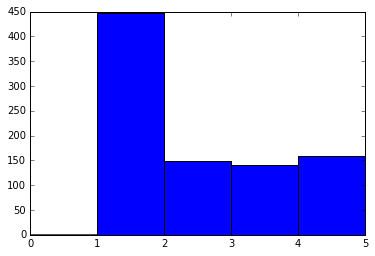

In [25]:
plt.hist(data.outside_barriers, bins=5, range=[0,5])
plt.show()

In `matplotlib`, there are no defaults around non-numeric data, including: 

1. where to place things
2. how to name things
3. how to summarize things

so the first things we'll need to do are create iterables with x values, x labels, and y values

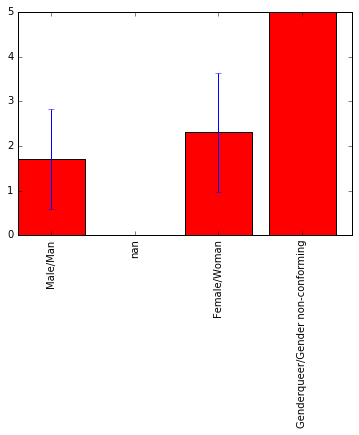

In [16]:
index = range(len(data.gender.unique()))
x_ticks = data.gender.unique()
y_vals = [data[data.gender == value].outside_barriers.mean() for value in x_ticks]
y_error = [data[data.gender == value].outside_barriers.std() for value in x_ticks]
plt.bar(index, y_vals, width=0.8, color = 'r', yerr=y_error)
plt.xticks([item + 0.4 for item in index], x_ticks, rotation=90)
plt.show()

We can try plotting the values for inside barriers versus outside barriers, to see if it looks like there is any kind of relationship there, but we're going to run into a problem...

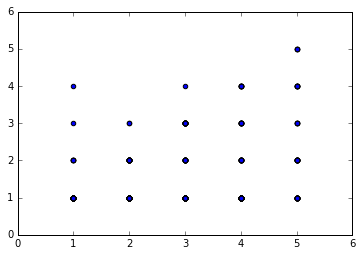

In [26]:
plt.scatter(data.outside_barriers, data.inside_barriers)
plt.show()

The problem that we have is that these are scales, with values like `1` and `2` - there are no floats like `1.189`, so the dots *all overlap*.

We can fix this by adding a little bit of random noise to each value.

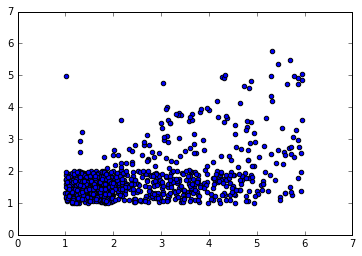

In [27]:
from numpy.random import random
x_vals = [value + random() for value in data.outside_barriers]
y_vals = [value + random() for value in data.inside_barriers]
plt.scatter(x_vals, y_vals)
plt.show()

`matplotlib` is very customizable, but that means it also has a steep learning curve. If you'd like to know more, D-Lab does a whole workshop just on this one library.

## Inferential statistics

pandas does not have statistical functions baked in, so we are going to call them from the `scipy.stats` library and the `statmodels` scikit.

We are also going to load in an actual dataset, as stats examples aren't very interesting with tiny bits of fake data.

In [71]:
from scipy import stats

Using what you've learned so far about manipulating pandas objects, how would you find out the names of the variables in this dataset? Their datatypes? The distribution of their values?

### Comparisons of group means

A common statistical procedure is to look for differences between groups of values. Typically, the values are grouped by a variable of interest, like sex or age. Here, we are going to compare the barriers of access to technology that people experience in the D-Lab compared to the world outside.

If you only have two groups in your sample, you can use a t-test:

In [73]:
i = data['inside_barriers'].dropna()
o = data['outside_barriers'].dropna()
stats.ttest_ind(i, o)

Ttest_indResult(statistic=-16.595371177338013, pvalue=1.2776894527836828e-57)

Notice that here, we are passing in two whole columns, but we could also be subsetting by some other factor.

If you have more than two groups (or levels) that you would like to compare, you'll have to use something like an ANOVA:

In [74]:
m = data[data.gender == "Male/Man"]['outside_barriers'].dropna()
f = data[data.gender == "Female/Woman"]['outside_barriers'].dropna()
q = data[data.gender == "Genderqueer/Gender non-conforming"]['outside_barriers'].dropna()
stats.f_oneway(m, f, q)

F_onewayResult(statistic=24.849003218034316, pvalue=3.2400472234376748e-11)

#### Linear relationships

Another common task is to establish if/how two variables are related across linear space. This could be something, for example, like relating shoe size to height. Here, we are going to ask whether barriers to access to technology inside and outside of the D-Lab are related.

One implementation of linear relationships is correlation testing:

In [76]:
intermediate = data.dropna(subset=['inside_barriers', 'outside_barriers'])
stats.pearsonr(intermediate['outside_barriers'], intermediate['inside_barriers'])

(0.46403957585300182, 2.075286653965493e-48)

At this point, we're going to pivot to using `statsmodels`

In [77]:
import statsmodels.formula.api as smf

The formulas module in statsmodels lets us work with pandas dataframes, and linear model specifications that are similar to R and other variants of statistical software, e.g.:

```
outcome ~ var1 + var2
```

In [78]:
model_1 = smf.ols("inside_barriers ~ outside_barriers", data=data).fit()
model_1

To get a summary of the test results, call the model's `summary` method

In [79]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        inside_barriers   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     242.0
Date:                Fri, 25 Mar 2016   Prob (F-statistic):           2.08e-48
Time:                        15:40:59   Log-Likelihood:                -807.74
No. Observations:                 884   AIC:                             1619.
Df Residuals:                     882   BIC:                             1629.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            0.7529      0.038     19.599      0.000         0.678     0.828
outside_barriers     0.2464      0.016     15.558      0.000         0.215     0.277
==============================================================================
Omnibus:                      389.637   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1871.839
Skew:                           2.026   Prob(JB):                         0.00
Kurtosis:                       8.865   Cond. No.                         5.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since Python does not have private data or hidden attributes, you can pull out just about any intermediate information you want, including coefficients, residuals, and eigenvalues

> Raymond Hettinger would say that Python is a "consenting adult language"

In [80]:
model_1.params['outside_barriers']

0.24638149915096663

`statsmodels` also exposes methods for validity checking your regressions, like looking for outliers by influence statistics

In [81]:
model_1.get_influence().summary_frame()

,dfb_Intercept,dfb_outside_barriers,cooks_d,dffits,dffits_internal,hat_diag,standard_resid,student_resid
0,-0.007772,0.000628,9.397542e-05,-0.013703,-0.013710,0.001134,-0.406955,-0.406762
1,0.000048,-0.000032,1.258195e-09,0.000050,0.000050,0.001902,0.001149,0.001149
2,0.000048,-0.000032,1.258195e-09,0.000050,0.000050,0.001902,0.001149,0.001149
3,0.002573,-0.020131,5.793345e-04,-0.034033,-0.034039,0.001740,-0.815305,-0.815150
4,0.000048,-0.000032,1.258195e-09,0.000050,0.000050,0.001902,0.001149,0.001149
5,0.000048,-0.000032,1.258195e-09,0.000050,0.000050,0.001902,0.001149,0.001149
6,0.000048,-0.000032,1.258195e-09,0.000050,0.000050,0.001902,0.001149,0.001149
8,0.000048,-0.000032,1.258195e-09,0.000050,0.000050,0.001902,0.001149,0.001149
9,0.000048,-0.000032,1.258195e-09,0.000050,0.000050,0.001902,0.001149,0.001149
10,0.031181,-0.062463,2.801289e-03,-0.074872,-0.074850,0.003721,-1.224749,-1.225096


If, at this stage, you suspect that one or more outliers is unduly influencing your model fit, you can transform your results into robust OLS with a method call:

In [82]:
model_1.get_robustcov_results().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        inside_barriers   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     101.0
Date:                Fri, 25 Mar 2016   Prob (F-statistic):           1.40e-22
Time:                        15:41:01   Log-Likelihood:                -807.74
No. Observations:                 884   AIC:                             1619.
Df Residuals:                     882   BIC:                             1629.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept            0.7529      0.036     21.041      0.000         0.683     0.823
outside_barriers     0.2464      0.025     10.052      0.000         0.198     0.294
==============================================================================
Omnibus:                      389.637   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1871.839
Skew:                           2.026   Prob(JB):                         0.00
Kurtosis:                       8.865   Cond. No.                         5.17
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

This isn't very different, so we're probably okay.

If you want to add more predictors to your model, you can do so inside the function string:

In [83]:
smf.ols("inside_barriers ~ outside_barriers + gender", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        inside_barriers   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     86.65
Date:                Fri, 25 Mar 2016   Prob (F-statistic):           7.02e-49
Time:                        15:41:01   Log-Likelihood:                -748.48
No. Observations:                 848   AIC:                             1505.
Df Residuals:                     844   BIC:                             1524.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------------------
Intercept                                       0.6550      0.045     14.680      0.000         0.567     0.743
gender[T.Genderqueer/Gender non-conforming]    -0.9480      0.588     -1.611      0.108        -2.103     0.207
gender[T.Male/Man]                              0.1808      0.043      4.209      0.000         0.096     0.265
outside_barriers                                0.2586      0.016     16.106      0.000         0.227     0.290
==============================================================================
Omnibus:                      358.447   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1650.675
Skew:                           1.940   Prob(JB):                         0.00
Kurtosis:                       8.626   Cond. No.                         76.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that our categorical/factor variable has been automatically one-hot encoded as treatment conditions. There's not way to change this within `statsmodels`, but you can specify your contrasts indirectly using a library called (`Patsy`)[http://statsmodels.sourceforge.net/stable/contrasts.html].

To add interactions to your model, you can use `:`, or `*` [for full factorial]

In [84]:
smf.ols("inside_barriers ~ outside_barriers * gender", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        inside_barriers   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     76.92
Date:                Fri, 25 Mar 2016   Prob (F-statistic):           1.26e-55
Time:                        15:41:02   Log-Likelihood:                -730.40
No. Observations:                 848   AIC:                             1471.
Df Residuals:                     843   BIC:                             1495.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        0.7909      0.049     16.101      0.000         0.695     0.887
gender[T.Genderqueer/Gender non-conforming]                     -0.0303      0.022     -1.364      0.173        -0.074     0.013
gender[T.Male/Man]                                              -0.2132      0.077     -2.753      0.006        -0.365    -0.061
outside_barriers                                                 0.1993      0.019     10.755      0.000         0.163     0.236
outside_barriers:gender[T.Genderqueer/Gender non-conforming]    -0.1514      0.111     -1.364      0.173        -0.369     0.066
outside_barriers:gender[T.Male/Man]                              0.2124      0.035      6.061      0.000         0.144     0.281
==============================================================================
Omnibus:                      351.976   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1805.642
Skew:                           1.851   Prob(JB):                         0.00
Kurtosis:                       9.115   Cond. No.                     3.96e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.92e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Practice

In the time remaining, pull up a dataset that you have, and that you'd like to work with in Python. The instructors will be around to help you apply what you've learned today to problems in your data that you are dealing with.

If you don't have data of your own, you should practice with the test data we've given you here. For example, you could try to figure out:

1. Do different departments have the same gender ratios?
2. What variable in this dataset is the best predictor for how useful people find our workshops to be?